In [6]:
import matplotlib.pyplot as plt
import numpy as np
import json
from scipy.stats import ttest_ind

In [7]:
# helper function to output plot and write summary data
def plot_results(results, random_counterpart=None, random_concepts=None, num_random_exp=100,
    min_p_val=0.05):
  """Helper function to organize results.
  When run in a notebook, outputs a matplotlib bar plot of the
  TCAV scores for all bottlenecks for each concept, replacing the
  bars with asterisks when the TCAV score is not statistically significant.
  If you ran TCAV with a random_counterpart, supply it here, otherwise supply random_concepts.
  If you get unexpected output, make sure you are using the correct keywords.
  Args:
    results: dictionary of results from TCAV runs.
    random_counterpart: name of the random_counterpart used, if it was used. 
    random_concepts: list of random experiments that were run. 
    num_random_exp: number of random experiments that were run.
    min_p_val: minimum p value for statistical significance
  """

  # helper function, returns if this is a random concept
  def is_random_concept(concept):
    if random_counterpart:
      return random_counterpart == concept
    
    elif random_concepts:
      return concept in random_concepts

    else:
      return 'random500_' in concept

  # print class, it will be the same for all
  print("Class =", results[0]['target_class'])

  # prepare data
  # dict with keys of concepts containing dict with bottlenecks
  result_summary = {}
    
  # random
  random_i_ups = {}
    
  for result in results:
    if result['cav_concept'] not in result_summary:
      result_summary[result['cav_concept']] = {}
    
    if result['bottleneck'] not in result_summary[result['cav_concept']]:
      result_summary[result['cav_concept']][result['bottleneck']] = []
    
    result_summary[result['cav_concept']][result['bottleneck']].append(result)

    # store random
    if is_random_concept(result['cav_concept']):
      if result['bottleneck'] not in random_i_ups:
        random_i_ups[result['bottleneck']] = []
        
      random_i_ups[result['bottleneck']].append(result['i_up'])
    
  # to plot, must massage data again 
  plot_data = {}
  plot_concepts = []
    
  # print concepts and classes with indentation
  for concept in result_summary:
        
    # if not random
    if not is_random_concept(concept):
      print(" ", "Concept =", concept)
      plot_concepts.append(concept)

      for bottleneck in result_summary[concept]:
        i_ups = [item['i_up'] for item in result_summary[concept][bottleneck]]
        
        # Calculate statistical significance
        _, p_val = ttest_ind(random_i_ups[bottleneck], i_ups)
                  
        if bottleneck not in plot_data:
          plot_data[bottleneck] = {'bn_vals': [], 'bn_stds': [], 'significant': []}

        if p_val > min_p_val:
          # statistically insignificant
          plot_data[bottleneck]['bn_vals'].append(0.01)
          plot_data[bottleneck]['bn_stds'].append(0)
          plot_data[bottleneck]['significant'].append(False)
            
        else:
          plot_data[bottleneck]['bn_vals'].append(np.mean(i_ups))
          plot_data[bottleneck]['bn_stds'].append(np.std(i_ups))
          plot_data[bottleneck]['significant'].append(True)

        print(3 * " ", "Bottleneck =", ("%s. TCAV Score = %.2f (+- %.2f), "
            "random was %.2f (+- %.2f). p-val = %.3f (%s)") % (
            bottleneck, np.mean(i_ups), np.std(i_ups),
            np.mean(random_i_ups[bottleneck]),
            np.std(random_i_ups[bottleneck]), p_val,
            "not significant" if p_val > min_p_val else "significant"))
        
  # subtract number of random experiments
  if random_counterpart:
    num_concepts = len(result_summary) - 1
  elif random_concepts:
    num_concepts = len(result_summary) - len(random_concepts)
  else: 
    num_concepts = len(result_summary) - num_random_exp
    
  num_bottlenecks = len(plot_data)
  bar_width = 0.35
    
  # create location for each bar. scale by an appropriate factor to ensure 
  # the final plot doesn't have any parts overlapping
  index = np.arange(num_concepts) * bar_width * (num_bottlenecks + 1)

  # matplotlib
  fig, ax = plt.subplots()
    
  # draw all bottlenecks individually
  for i, [bn, vals] in enumerate(plot_data.items()):
    bar = ax.bar(index + i * bar_width, vals['bn_vals'],
        bar_width, yerr=vals['bn_stds'], label=bn)
    
    # draw stars to mark bars that are stastically insignificant to 
    # show them as different from others
    for j, significant in enumerate(vals['significant']):
      if not significant:
        ax.text(index[j] + i * bar_width - 0.1, 0.01, "*",
            fontdict = {'weight': 'bold', 'size': 16,
            'color': bar.patches[0].get_facecolor()})
  print (plot_data)
  # set properties
  ax.set_title('TCAV Scores for each concept and bottleneck')
  ax.set_ylabel('TCAV Score')
  ax.set_xticks(index + num_bottlenecks * bar_width / 2)
  ax.set_xticklabels(plot_concepts)
  ax.legend()
  fig.tight_layout()
  plt.show()

In [8]:
res_2_2 = json.load(open("results/results_10_5_2911.json"))

Class = zebra
  Concept = striped
    Bottleneck = mixed3a. TCAV Score = 0.00 (+- 0.00), random was 0.53 (+- 0.37). p-val = 0.006 (significant)
    Bottleneck = mixed3b. TCAV Score = 0.40 (+- 0.49), random was 0.42 (+- 0.36). p-val = 0.904 (not significant)
    Bottleneck = mixed4a. TCAV Score = 0.50 (+- 0.32), random was 0.53 (+- 0.29). p-val = 0.874 (not significant)
    Bottleneck = mixed4b. TCAV Score = 0.50 (+- 0.32), random was 0.53 (+- 0.37). p-val = 0.895 (not significant)
    Bottleneck = mixed4c. TCAV Score = 0.30 (+- 0.24), random was 0.50 (+- 0.45). p-val = 0.365 (not significant)
    Bottleneck = mixed4d. TCAV Score = 0.20 (+- 0.24), random was 0.45 (+- 0.38). p-val = 0.197 (not significant)
    Bottleneck = mixed4e. TCAV Score = 0.70 (+- 0.24), random was 0.53 (+- 0.43). p-val = 0.412 (not significant)
    Bottleneck = mixed5a. TCAV Score = 1.00 (+- 0.00), random was 0.55 (+- 0.47). p-val = 0.052 (not significant)
    Bottleneck = mixed5b. TCAV Score = 0.80 (+- 0.24), ran

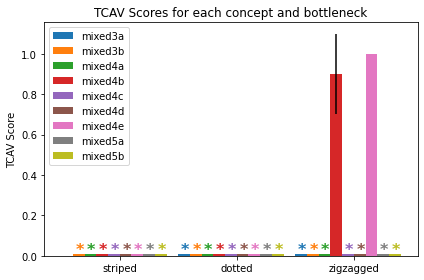

In [9]:
# remember to change num_random_exp
plot_results(res_2_2, num_random_exp=5)